# **深度学习公开课 - 深度学习中的时间序列算法群**
> 节选自《深度学习实战》第7期正课<br>
> 作者：@菜菜TsaiTsai<br>
> 版本号：2023/10/20<br>

## **<center><font color ="k">公开课Day2 LSTM参数全解与股价数据预测实战<br><br>极致易学 | 高效入门 | 前景讨论<center>**<br>**<center><font color ="red">直播将于8点30分正式开始！<br><br>扫码回复"DL999"领取今日直播课件>>><br><br>扫码回复"优惠"抢直播间专属优惠券>>></font></center>**

## 0 课程规划

欢迎来到《深度学习中的时间序列算法群》公开课。在这门课程中，我将带你从0认识3大类深度学习中的时间序列模型，并为你深度讲解深度时序算法众多的的精彩理念与实现方式。当你完成这门课程时，你将完成深度时序算法入门，打好进一步学习更多高级架构的基础。

**DAY 1：LSTM与深度学习中的时间序列**
1. 深度学习中的时间序列数据
2. 时序数据 vs 非时序数据
3. 循环神经网络如何处理时序问题
4. LSTM的灵感起源与直觉理解
5. LSTM的基本结构与架构设计

**DAY 2：LSTM的参数全解与预测实战**
1. PyTorch中的LSTM层与参数
2. LSTM在时序数据上的预测实战
3. 深度学习中的时间序列解决方案
……

更多后续课程请关注B站动态和小可爱私聊信息！

## 1 回顾：LSTM的原理与基本结构

长短期记忆网络（Long Short-Term Memory Network，简称LSTM）是一种特殊的循环神经网络，它于1997年被慕尼黑技术大学的两位神经网络研究者提出，是当代深度学习领域中对时序数据和文字数据都具有重要作用的核心架构之一。在NLP的世界中，RNN为神经网络赋予了“记忆”的能力，LSTM则实现了对这种“记忆”方式的改良和优化。

首先，从**直觉**上来看，RNN的“记忆机制”存在两大关键问题：

- **所有信息照单全收，毫无重点**

RNN是按顺序依次处理数据集的，这个流程计算量繁重、计算效率很低，因此为了节约计算资源、降低运算复杂度，RNN有着“全样本共享权重w的权重共享机制”。对时间序列来说，就是所有时间点都使用同样的权重来进行处理，对文字来说，就是所有语义的文字都使用同样的权重来进行处理。因此在吸纳信息时，RNN就**无法辨别不同时间点上的信息对未来的不同影响**，在使用这些信息进行预测的时候，RNN**也无法辨别不同时间步上的标签最需要的信息是哪些**，这会严重影响算法的整体预测效果。到今天，这依然是影响RNN预测效果的关键因素之一。

- **新信息强制覆盖旧信息，导致遗忘**

在RNN中，隐藏状态$H_t$在每个时间步都会进行更新：

$$
\begin{align}
H_t &= f(\color{red}{W_{hh}H_{t-1}} + W_{xh}X_{t}) \\ \\
H_{t+1} &= f(W_{hh}f(\color{red}{W_{hh}H_{t-1}} + W_{xh}X_{t}) + W_{xh}X_{t+1}) \\ \\
H_{t+2} &= f(W_{hh}f(W_{hh}f(\color{red}{W_{hh}H_{t-1}} + W_{xh}X_{t}) + W_{xh}X_{t+1}) + W_{xh}X_{t+2}) \\ \\
&......
\end{align}
$$

其中f是sigmoid函数，所以$H_t$的大小会始终被控制在[0,1]之间。在更新过程中，不断有新的$X_t$被加入到隐藏状态当中，这一加法过程就会自然地挤压历史信息$H_{t-1}$在$H_t$、$H_{t+1}$、$H_{t+2}$等未来的隐藏状态中所占的信息比重。当时间步的数量太多、序列太长的时候，历史信息所占的比重就会被压缩到一定程度，此时许多历史信息对$H_t$的影响就可以忽略不计，等同于RNN将这部分历史信息给遗忘了。

基于以上两点问题，研究者们在设计LSTM的时候存在一个根本诉求——<font color="red">**要创造一个全新的架构、一套全新的数据流，为循环神经网络赋予选择性记忆和选择性传递信息的能力**</font>。这里的选择性包含多层含义，包括：

**1. 循环网络必须自行选择吸纳多少新信息**，只留重点，拒绝照单全收

**2. 循环网络必须自行选择遗忘多少历史信息**，主动遗忘无效内容，保留有效内容

**3. 循环网络必须自行判断、对当前时间步的预测来说最重要的信息是哪些，并将该信息输出给当前时间步**，这样既可以保证当前时间步上的预测是最高效的，也不会影响向下一个时间步传递的信息。

在这三个能力当中，前两个能力允许循环神经网络决定“哪些长期信息会被传递下去”，最后一个能力允许循环神经网络决定“哪些短期信息对当前时间步的预测是最重要的”。这三种能力构成了LSTM的基本结构。

- **记忆细胞**

首先，**LSTM依然是一个循环神经网络，因此LSTM的网络架构与RNN高度相似，同时LSTM也是需要遍历所有时间步，不断完成循环和嵌套的**。但不同的是，RNN由输入层（输入$X_t$）、隐藏层和输出层（输出$Y_t$）构成，而LSTM由输入层（输入$X_t$）、**记忆细胞（Memory Cell）**和输出层（输出$Y_t$）构成，其中输入、输出层与RNN的输入、输出层完全一致，而记忆细胞是LSTM独有的结构。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/02_.png)

**记忆细胞是LSTM的基本计算单元，在记忆细胞中，我们分割长期信息与短期信息，同时赋予循环网络对信息做选择的能力**。在之前我们提到，循环网络必须自行决定哪些长期信息会被传递下去，哪些短期信息对当前的预测最为有效，因此在记忆细胞当中，LSTM设置了两个关键变量：

> - **主要负责长期记忆的细胞状态$C$**
> - **主要负责记忆短期信息、尤其是当前时间步信息的隐藏状态$h$，**以及

这两个变量都随着时间步进行迭代。如上图所示，在迭代开始时，LSTM会同时初始化$h_0$和$C_0$；在任意时间步t上，记忆细胞会同时接受到来自上一个时间步的长期记忆$C_{t-1}$、短期信息$h_{t-1}$以及当前时间步上输入的新信息$X_t$三个变量，结合三者进行运算后，记忆细胞会输出当前时间步上的长期记忆$C_{t}$和短期信息$h_{t}$，并将它们传递到下一个时间步上。同时，在每个时间步上，$h_t$还会被传向当前时间步的输出层，用于计算当前时间步的预测值$\hat{y}_t$。

那在记忆细胞的内部，究竟是如何进行具体的$C_t$和$h_t$计算的呢？来看看记忆细胞内部的流程图：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE1.png)

这是一个复杂的流程，但在横向上，它可以被分割为C的传递和h的传递两条路径；在纵向上，它可以被分为如图所示的三个不同的路径：

**1. 帮助循环网络选择吸纳多少新信息的输入门**

**2. 帮助循环网络选择遗忘多少历史信息的遗忘门**，以及

**3. 帮助循环网络选择出对当前时间步的预测来说最重要的信息、并将该信息输出给当前时间步的输出门**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%B5%81%E7%A8%8B%E5%9B%BE2.png)

让我们分别来看一下三个门是如何工作的。

- **遗忘门**

**遗忘门是决定要留下多少长期信息C的关键计算单元，其数学本质是为上一个时间步传入的$C_{t-1}$赋予一个[0,1]之间的权重，以此筛选掉部分旧信息。**在这个计算过程中，假设遗忘门赋予$C_{t-1}$的权重为0.7，那就是说遗忘门决定了要保留70%的历史信息，遗忘30%的历史信息，这30%的信息空间就可以留给全新的信息来使用。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/09.png)

那权重是如何被计算出来的呢？如图所示，遗忘门会参考当前时间步的信息$X_t$与上一个时间步的短时信息$h_{t-1}$来计算该权重，其中$\sigma$是sigmoid函数，$w_f$是动态影响最终权重大小的参数，$f_t$就是[0,1]之间的、用于影响$C_{t-1}$的权重。

P.S. 注意，在以往的课程中，我们会将$w$称之为是权重，在LSTM中为区分我们将其称为算法的参数。

在LSTM的设计逻辑之中，考虑$X_t$和$h_{t-1}$实际是在考虑离当前时间步最近的**上下文信息**，而参数$w_f$会受到**损失函数和算法整体表现的影响，不断调节遗忘门中计算出的权重f的大小**，因此遗忘门能够结合上下文信息、损失函数传来的梯度信息、以及历史信息共同计算出全新的、被留下的长期记忆$C_t$。这个流程在实践中被证明是十分有效的。

- **输入门**

**输入门是决定要吸纳多少新信息来融入长期记忆C的计算单元，其数学本质是为当前时间步传入的所有信息赋予一个[0,1]之间的权重，以筛选掉部分新信息，将剩余的新信息融入长期记忆C**。

在这个计算过程中，我们首先要计算出当前时间步总共吸收了多少全新的信息$\tilde{C}_t$，这个计算全新信息的方式就与RNN中计算$h_t$的方式高度相似，因此也会包含用于影响新信息传递的参数$W_C$和RNN中常见的tanh函数。然后，我们要依据上下文信息（依然是$X_t$和$h_{t-1}$）以及参数$W_i$来生成筛选新信息的权重$i_t$。最后我们将二者相乘，并加入到长期记忆$C$当中。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/07.png)

可以看到，相比起RNN的数据输入过程，LSTM的输入过程灵活了非常多——在输入门当中，我们不仅对输入数据加上了一个传递的权重$i_t$，还分别使用了两个受损失函数影响的参数$W_i$和$W_C$来控制新信息聚合和权重生产的流程。在权重和两大参数的作用下，输入数据可以被高度灵活地调节，以便满足最佳的损失函数需求。

- **更新细胞状态**

当遗忘门决定了哪些信息要被遗忘，输入门决定了哪些信息要被加入到长期记忆后，就可以更新用于控制长期记忆的细胞状态了。如下图所示，上一个时间步的长期记忆将乘以遗忘门的权重，再加上新信息$\tilde{C}_t$乘以新信息筛选的权重$i_t$，同时考虑放弃过去的信息、容纳新信息，以此来构成传递给下一个时间步的长期信息$C_t$。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/03.jpg)

- **输出门**

最后我们来到了输出门。**输出门是从全新的长期信息$C_t$中筛选出最适合当前时间步的短期信息$h_t$的计算单元，其数学本质是对已经计算好的长期信息$C_t$赋予一个[0,1]之间的权重，以此筛选出对当前时间步最有效的信息用于当前时间步的预测**。具体流程如下所示：

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/08.png)

这个流程分为三步:
1. 首先要借助上下文信息和参数$W_o$来求解出权重$o_t$
2. 对长期信息$C_t$进行tanh标准化处理
3. 将$o_t$乘在标准化后的长期信息$C_t$之上，用于筛选出$h_t$。

为什么要对长期信息$C_t$做标准化处理呢？在LSTM的论文中如此写到：Tanh标准化可以限制有效长期信息$C_t$的数字范围，避免历史信息在传递过程中变得越来越大，同时还能为输出门赋予一定的非线性性质，这个过程被实践证明有助于保持训练稳定、还能够强化算法学习能力，因此在LSTM最终的设计中被保留下来。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/01.png)

这就是记忆细胞的全部数学过程。很显然，在这个过程中我们能够看到LSTM是如何为RNN赋予了各种灵活的能力，从而实现了多个层次上的“信息筛选”。很显然，LSTM通过分割长短期信息、以及设置3大门的方式，彻底改善了循环神经网络在信息筛选方面的困境。

## 2 LSTM在PyTorch中的参数与实现

在之前的课程当中，我们已经认识了PyTorch框架的基本结构，整个PyTorch框架可以大致被分Torch和成熟AI领域两大板块，其中Torch包含各类神经网络组成元素、用于构建各类神经网络，各类AI领域中则包括Torchvision、Torchtext、Torchaudio等辅助完成图像、文字、语音方面各类任务的领域模块。

在PyTorch中，LSTM是属于“构建循环神经网络的元素”，而非“成熟神经网络”，因此LSTM是位于PyTorch.nn这个基本模块下。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/24.png)

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/25.png)

来看看位于torch.nnm模块下的lstm层：

`nn.LSTM(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)`

LSTM类与RNN类高度相似，这两个类的参数都很少、结构相当简单。虽然该类的名字叫做LSTM，但实际上**nn.LSTM并不是完整的LSTM算法，而是LSTM中的输入层和隐藏层**。nn.LSTM的输入层是在线性层的基础上改进后的层，隐藏层则是包含记忆细胞的层，这两个层除了最基本的匹配权重、神经元结果加和、激活函数、向前向后传播等功能外，还负责执行我们在讲解RNN和LSTM的原理时提到的“将上个时间步的中间变量传递给下个时间步”的功能。对RNN来说，我们传递的是隐藏状态$h_t$，对LSTM来说，我们同时传递细胞状态$C_t$和隐藏状态$h_t$。

我们来看看这些nn.LSTM的几个重要参数：

- `input_size`: 输入特征的数量，也是输入层的神经元数量。对输入数据为三维数据的LSTM来说，input_size应当等于三维时间序列数据中的input_sizeension。

- `num_layers`：隐藏层的数量。如下图所示，左侧就是一个隐藏层数量为1的LSTM，右侧就是隐藏层数量为3的LSTM。

- `hidden_size`: 隐藏层的神经元数量，对LSTM来说就是隐藏层上的记忆细胞的数量。在下图中，每个隐藏层上的记忆细胞（神经元）数量是5个。与RNN一致，在LSTM中我们一般默认全部隐藏层上的神经元数量是一致的。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE1.png)

- `drop_out`: 在神经网络中常见的抗过拟合机制，在Pytorch被内置在LSTM里帮助对抗过拟合。Dropout是在神经网络传播过程中，随机让部分参数为0的抗过拟合方法。令参数为0，就可以切断神经网络层与层之间的链接，从而切断信息的传播，以此来阻碍神经网络的学习，达到对抗过拟合的目的：

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*iWQzxhVlvadk6VAJjsgXgg.png)

这一参数中我们一般填写[0,1)之间的小数。例如填写0.5，就代表在每次正向传播中，随机令50%的参数为0。这一随机性是不可控制的，任何随机数种子都不能让Dropout的随机性变得固定，因此Dropout会让神经网络的训练过程变得无法复现。

在LSTM中，Dropout被施加在**隐藏层与隐藏层之间，而不是记忆细胞之间，也就是说Dropout是施加在$h_t$通向输出层的传播路径上，而不影响$C_t$和$h_t$在时间步上的传播路径**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE2.png)

需要注意的是，和任意神经网络中的Dropout模式一致，`dropout`参数默认会在训练过程中起作用，而在模型的预测、评估或推理阶段不起作用。因此在训练LSTM的时候，我们会需要使用 `train()` 和 `eval()` 两种模式来帮助模型分辨当前正在进行的是训练还是预测任务。

- `batch_first`: 如果为True，输入和输出Tensor的形状为 [batch_size, seq_len, input_sizeension]，否则为[seq_len, batch_size, input_sizeension]。当数据是时间序列数据时，seq_len是time_step。注意，默认值为False，所以pytorch官方所使用的结构是[seq_len, batch_size, input_sizeension]。注意，**和循环神经网络一致的是，LSTM一定会遵循时间步的方式进行循环，因此确定正确的时间步维度非常重要！**

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/22.png)

注意，**LSTM类允许输入二维时间序列（即结构为[seq_len, input_sizeension]的序列）和三维时间序列（架构为[batch_size, seq_len, input_sizeension]）**。不过参数`batch_first`只会在输入时间序列为三维的时候有效。当输入时间序列为二维时，batch_first参数无效。

同时，LSTM类有三个输出，一个是`output`，一个是`hn`，还有一个是`cn`——

- `output`：代表所有时间步上最后一个隐藏层上输出的隐藏状态的集合（如图所示，是红色方框中的方向上的隐藏状态的集合）。很显然，对单层的LSTM来说，output代表了唯一一个隐藏层上的隐藏状态。output的形状都为 [seq_len, batch_size, hidden_size]，不受隐藏层数量的影响。**注意，当参数batch_first=True时，output的形状为**[batch_size, seq_len, hidden_size]。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE3.png)

- `hn`: 最后一个时间步的、所有隐藏层上的隐藏状态。形状为 [num_layers, batch_size, hidden_size]。无论`batch_first`参数是什么取值，都不改变hn的输出。

- `cn`：最后一个时间步的、所有隐藏层上的细胞状态。形状为 [num_layers, batch_size, hidden_size]。无论`batch_first`参数是什么取值，都不改变cn的输出。

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/LSTM%E6%9E%B6%E6%9E%84%E5%9B%BE4.png)

不难发现，虽然LSTM的每个时间步、每个隐藏层都会输出隐藏状态h和细胞状态C，但是LSTM类却只会“选择性”地帮助我们输出部分隐藏状态，例如output在深层神经网络中只会保留最后一个隐藏层的隐藏状态，而hn和Cn则是只显示最后一个时间步的隐藏状态。不难发现，其实output、hn、cn都不能代表nn.LSTM层在循环中所传输的全部信息，它们都只能代表部分信息。

当然，在很多情况下，我们确实也只会关心最后一个时间步的隐藏状态，或者最后一个隐藏层的隐藏状态。output关注全部时间步，hn关注全部隐藏层，在NLP经典任务当中——

- 如果我们需要执行对**每一个时间步**进行预测的任务（比如，预测每一分钟的股价，预测明天是否会下雨，预测每个单词的情感倾向，预测每个单词的词性），此时我们就会关注每个时间步在最后一个隐藏层上的输出。此时我们要关注的是整个output。

- 如果我们需要执行的是对**每个时间序列表单、每个句子**进行预测的任务时（比如对句子进行情感分类，预测某个时间段内用户的行为、看过所有的句子之后对后续的文字进行生成等任务），我们就只会关注最后一个时间步的输出。此时我们更可能使用hn或者cn来进行下一步的预测。同时，在进行生成式的任务的时候，我们大概率也只关心最后一个时间步上的输出。

需要注意的是，无论是output还是hn还是cn，都只是lstm层的输出，不是整个神经网络真正的输出，**因为nn.LSTM层缺乏关键性结构：输出层**。因此在构建网络的时候，我们需要在LSTM层之后再增加一个输出层（通常是线性层），用于补完整个网络架构。

## 3 LSTM在单变量股价数据集上的预测实战

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

LSTM（长短时记忆网络）在时间序列预测领域中占据了重要地位，特别是在诸如股价预测这类复杂的金融时序任务中。时间序列预测可以根据其数据结构被划分为单变量、多变量以及更复杂的时序预测。对于这些预测任务，无论是单一的股票价格趋势，还是基于多个市场因子的股价联动性，或是本次我们关注的蛋白能量时间序列，LSTM都能为我们提供有力的工具。

一般来说，使用LSTM进行时间序列预测的基本流程如下——

- **数据预处理**：时间序列的数据预处理是一个复杂的过程，可能涉及到使用**动态的标准**来进行数据的编码、缺失值处理、数据大小的处理、对数据进行滑窗、对数据进行分割等等。

- **数据导入**：对深度学习数据来说，可能我们需要先将数据处理好，再导入为tensor。对于相对简单的数据，或许可以直接使用FloatTensor之类的工具进行转换，但对于结构复杂、或者尺寸过大的数据，则一般需要自定义继承自Datasets的数据导入函数。该流程的核心职责是将普通数据集整理出成深度学习算法所必须的输入形式，大部分时候数据导入的代码非常灵活，而且会根据数据的情况发生变化，十分复杂。

举例说明，来看下面的数据——

In [4]:
data = pd.read_csv(r"C:\Users\Shuyu\Desktop\new_feature.csv")

In [5]:
data.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,...,ExpMovingAvg_70Day,expand_mean,Upper_Shadow,Lower_Shadow,Date_year,Date_month,Date_day,Date_quarter,Date_weekofyear,Date_dayofweek
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730,...,2742.000000,2742.0,13.0,4.0,2017,1,4,1,1,2
1,2017-01-04,8185,2800.0,2847.0,2785.0,2846.0,57500,1.0,0,0.015827,...,2741.887324,2740.0,1.0,15.0,2017,1,4,1,1,2
2,2017-01-04,2698,1770.0,1783.0,1764.0,1778.0,45700,1.0,0,0.005062,...,2741.834160,2740.0,5.0,6.0,2017,1,4,1,1,2
3,2017-01-04,8182,1482.0,1512.0,1482.0,1510.0,50700,1.0,0,0.000649,...,2742.007846,2742.0,2.0,0.0,2017,1,4,1,1,2
4,2017-01-04,2702,3090.0,3090.0,3050.0,3060.0,384900,1.0,0,0.000000,...,2742.092132,2742.6,0.0,10.0,2017,1,4,1,1,2


In [9]:
data.shape

(2332531, 118)

还有一些非常重要的流程是——

- **架构定义**：根据我们所了解的数据情况，自定义基于LSTM层的各类架构。最为简单的方式就是在PyTorch中自定义神经网络类，当然也可以使用Huggingface中的一系列高级LSTM相关融合架构。

- **定义训练流程所需的全部代码**：在这个过程中，我们需要定义各类超参数、定义损失函数、定义优化算法、定义是否使用GPU、决定是否进行early stop、决定打印怎样的内容、决定是否进行持续的模型保存等等具体的流程。幸运的是，深度学习中的训练代码都是十分类似的。

- **进行初次训练，根据初次训练结果调整模型架构、模型参数、训练流程**

- **不断进行训练、决定是否完成数据增强等工作**

在今天我们的公开课当中，我将为你抛砖引玉，跑通一套最为简单的训练和预测实战流程，进行最为初级的“实战”。

- **数据导入与简单绘图**

In [39]:
data = pd.read_csv(r"C:\Users\Shuyu\Desktop\single_stock.csv",index_col=0)

In [55]:
data.head()

,Date,Close
0,2017-01-04,2742.0
1,2017-01-05,2738.0
2,2017-01-06,2740.0
3,2017-01-10,2748.0
4,2017-01-11,2745.0


In [24]:
data.shape

(1202, 3)

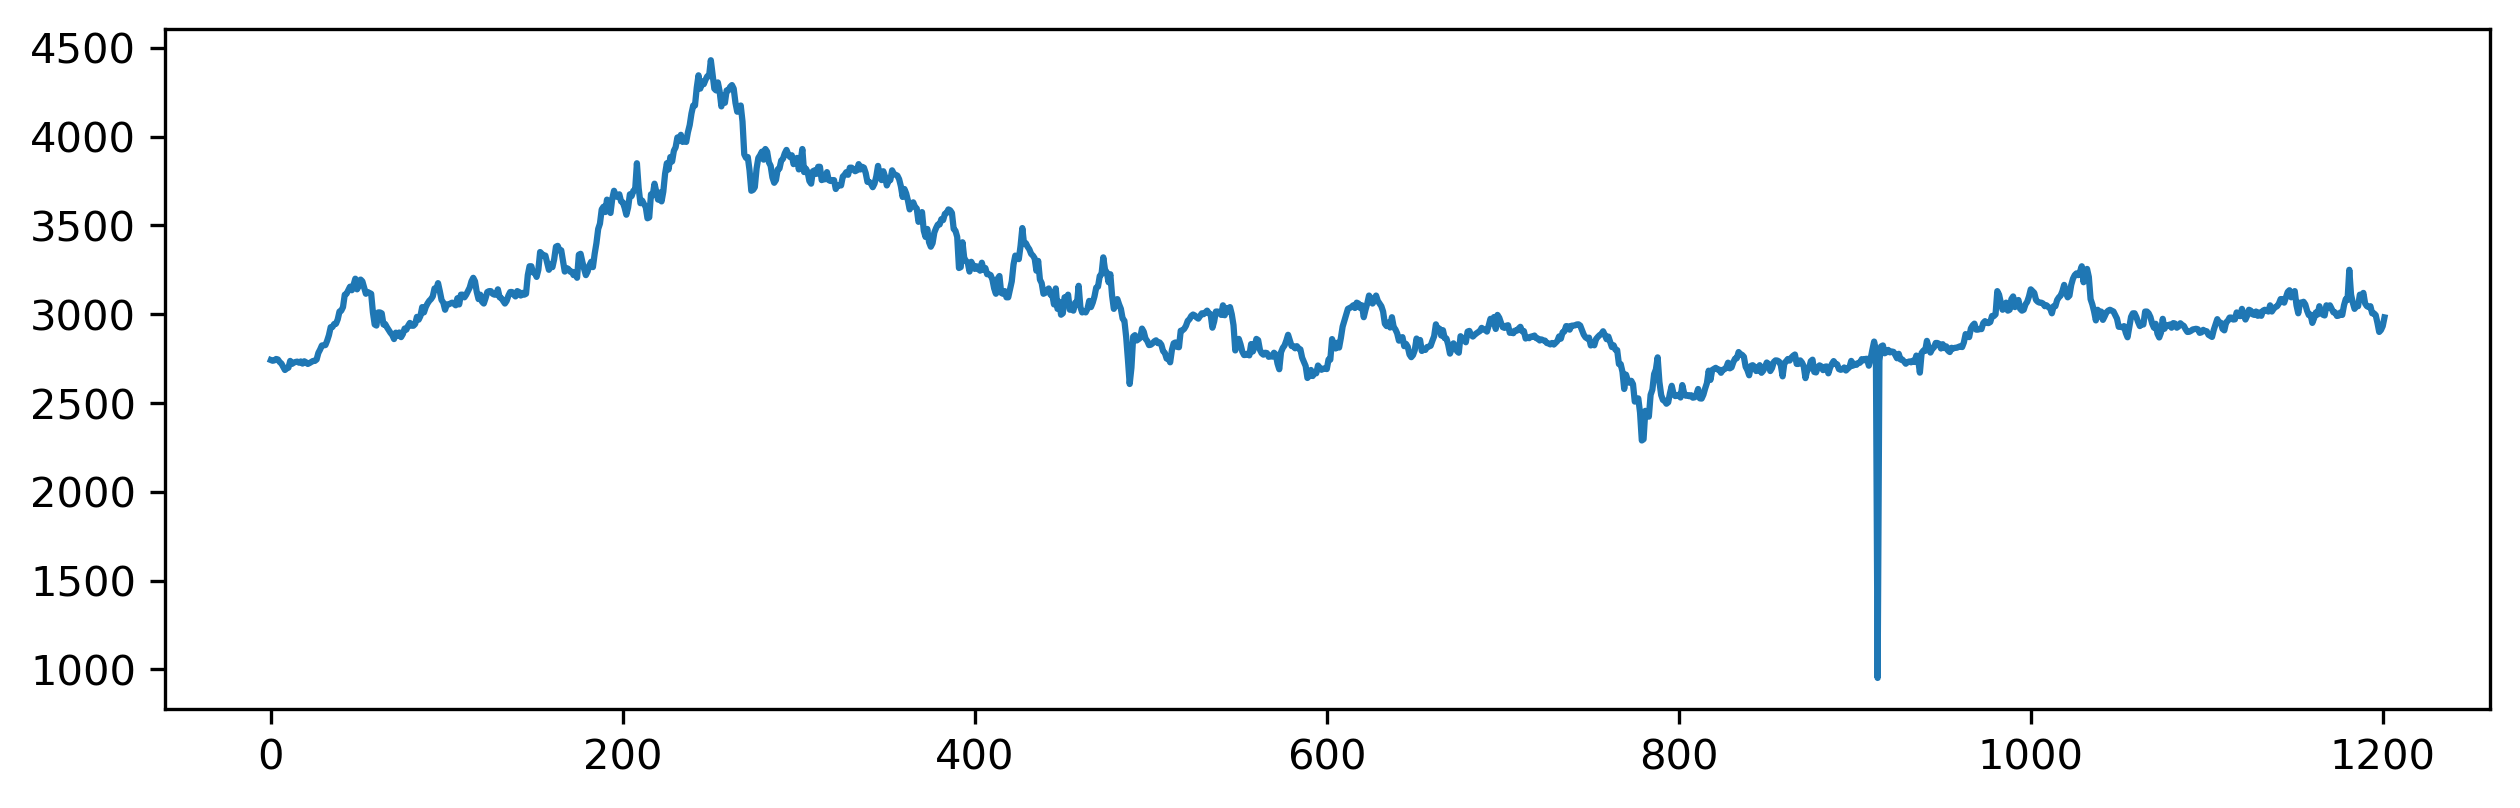

In [34]:
timeseries = data[["Close"]].values.astype('float32')

plt.figure(dpi=300,figsize=(10,3))
plt.plot(timeseries)
plt.show()

- **训练集与测试集分割**

In [41]:
#不能改变时间顺序，因此没有使用train_test_split等操作
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [46]:
train.shape

(805, 1)

In [47]:
test.shape

(397, 1)

In [87]:
# Convert data into Tensors
train_tensor = torch.FloatTensor(train).view(-1, train.shape[0], 1)
test_tensor = torch.FloatTensor(test).view(-1, test.shape[0], 1)

In [88]:
train_tensor.shape

torch.Size([1, 805, 1])

In [89]:
test_tensor.shape

torch.Size([1, 397, 1])

- **定义网络架构**

In [107]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=True)

        #输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #初始化h0和c0
        h0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        #LSTM的向前传播，此时我们关注的是所有时间步上的输出，还是最后一个时间步上的输出？
        #所有时间步上的输出，因此我们要输出的是output，而不是hn和cn
        output, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))

        #output的结构为[batch_size, seq_len, hidden_size]
        #因此我们要取出对我们有用的维度
        out = self.fc(output[:, :, :])
        return out

In [114]:
model = LSTMModel() #实例化
model(train_tensor).shape #尝试查看输出数据的结构

torch.Size([1, 805, 1])

- **损失要多少才算合理？**

In [115]:
def MSE(Y_ture,Y_predict):
    return ((Y_ture - Y_predict)**2).sum()/Y_ture.shape[0]

如果不使用神经网络预测，只将均值当做预测标签计算MSE的话——

In [116]:
MSE(train,train.mean())

181625.20248447204

In [117]:
MSE(test,test.mean())

35148.75818639799

- **第一轮超参数设置与架构设置**

In [113]:
#超参数设置
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
learning_rate = 0.01
num_epochs = 300

#实例化模型
model1 = LSTMModel(input_size, hidden_size, num_layers, output_size)

#定义损失函数与优化算法
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

#开始进行训练的循环
for epoch in range(num_epochs):
    outputs = model1(train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor[:, :, :])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("训练完成")

Epoch [50/300], Loss: 10208146.0000
Epoch [100/300], Loss: 10165716.0000
Epoch [150/300], Loss: 10129233.0000
Epoch [200/300], Loss: 10094029.0000
Epoch [250/300], Loss: 10048600.0000
Epoch [300/300], Loss: 10000588.0000
训练完成


In [120]:
model1.eval()
test_outputs = model1(test_tensor).detach().numpy()
MSE(test,test_outputs)

8168489.914357683

从上述训练结果中，不难发现以下问题：

1. **初始损失非常高**，可能说明模型学习能力或初始化技巧有很大的问题

2. **损失下降速度非常缓慢**，说明学习效率和迭代效率有很大问题

3. **迭代次数明显不够**，在300个epoch之后损失是直接使用均值进行预测的30多倍……

4. **测试集上的损失也非常高**，模型处于完全失效的状态

因此，我们可以采取以下的解决方案：

1. **增加LSTM的复杂度**来提升学习能力，现在的LSTM架构过于简单，难以满足当前任务的需求。

2. 如何提升学习效率和迭代效率？**提升学习率**，同时也可以提升batch_size（如果有batch_size的话）。

3. **增加总迭代次数**，给模型更多的训练空间

- **第二轮超参数与架构设置**

In [122]:
#超参数设置
input_size = 1
hidden_size = 100
num_layers = 5
output_size = 1
learning_rate = 0.1
num_epochs = 1500

#实例化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

#定义损失函数与优化算法
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#开始进行训练的循环
for epoch in range(num_epochs):
    outputs = model(train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor[:, -1, :])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 150 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("训练完成")

Epoch [150/1500], Loss: 3233892.7500
Epoch [300/1500], Loss: 1416913.1250
Epoch [450/1500], Loss: 535400.3125
Epoch [600/1500], Loss: 159067.1250
Epoch [750/1500], Loss: 49066.5977
Epoch [900/1500], Loss: 8391.8633
Epoch [1050/1500], Loss: 677.6950
Epoch [1200/1500], Loss: 293.2071
Epoch [1350/1500], Loss: 246.6494
Epoch [1500/1500], Loss: 287.8425
训练完成


In [132]:
model.eval()
test_outputs = model(test_tensor).detach().numpy()
MSE(test,test_outputs)

155726.35768261965